In [2]:
import sys
import importlib

sys.path.append("../")

from src import utils
from src.utils import *

from src import plot_utils
from src import graph_utils
from src import inpaint_utils
from src import fiberatlas_utils

## Goal

The goal of this notebook is to do inpainting. Allowing for negative weightings of bundle to generate bundles, and allowing as well negatively connected bundles to exist

## Description

In [3]:
scale = 1
connFilename = f'../../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5'
hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))
nsubject = hf.get('header').get('nsubjects')[()]
dim = hf.get('header').get('dim')[()]
fiber_affine = hf.get('header').get('affine')[()]

gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = gmregions_names.shape[0]

# NOTE; use the masks if necessary when 
# we select too much bundles for reconstruction
gm_mask_subj = nib.load('../../atlas_data/moviedata_fMRI_eg/gm_mask_subj7.nii').get_fdata() 
wm_mask_subj = (gm_mask_subj + 1) % 2


consistency_view = fiberatlas_utils.get_aggprop(hf, 'consistency')
length_view = fiberatlas_utils.get_aggprop(hf, 'length')
nbStlines_view = fiberatlas_utils.get_aggprop(hf, 'numbStlines')
nb_regions = consistency_view.shape[0]

# region_of_interest = ['ctx-rh-posteriorcingulate', 'ctx-lh-posteriorcingulate']
# index_of_interest = [np.where(gmregions_names.astype(str) == r)[0][0] 
#                      for r in region_of_interest]

# index_of_interest = np.array(index_of_interest)
# gmregions_names[index_of_interest]

### Prepare matrices for regression

In [10]:
thresh_subjapp = int(np.ceil(nsubject * 0.1)) # consider bundles that appear at least in 30 % of the subjects

region_ftimecourse = load(f"../../atlas_data/moviedata_fMRI_eg/yasseratlased_fmri/ftimecourse_95_scale{scale}.pkl")
regions_in_voxels = load(f'../../atlas_data/fiber_atlas/regions95_voxels_scale{scale}.pkl')[:,:,:,1:]

In [5]:
# Generating the X samples and the y samples
# 1. Careful as well to remove the auto-correlation in the diagonal
# 2. Raster scan parsing meaning that it is the activity of (R0,R1) -> (R0,R2) -> (R0,R3) etc...
# Define matrix of end points on cortex
X = []
bundles_labels = []
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = fiberatlas_utils.get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundles_labels.append((i,j))
        vec = np.zeros(nb_regions)
        vec[i-1] = 1.0
        vec[j-1] = 1.0
        X.append(vec)

X = np.array(X)
X_norm = (np.diag(1/X.sum(axis=0)) @ X.T).T

# GENERATING caring about voxel percentage

root = '../../atlas_data/fiber_atlas/yasser_datacomp/volspams_compress/'

atlas_of_interest = f'compresslausanne2018.scale{scale}.sym.corrected.ctx+subc.volspams.nii.gz'

prob_regions, prob_affine = (nib.load(root + atlas_of_interest).get_fdata()[:,:,:,1:], 
                             nib.load(root + atlas_of_interest).affine)

Xp = []
bundles_labels = []
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = fiberatlas_utils.get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundle_coords = tmp[:,[0,1,2]]

        prob_vox = np.zeros_like(prob_regions[:,:,:,0])
        prob_vox[bundle_coords[:,0], bundle_coords[:,1], bundle_coords[:,2]] = 1.0

        region_i = prob_regions[:,:,:,i-1]
        region_j = prob_regions[:,:,:,j-1]

        bundle_proba_i = (region_i * prob_vox)
        bproba_i = bundle_proba_i[bundle_proba_i!=0].mean()
        bundle_proba_j = (region_j * prob_vox)
        bproba_j = bundle_proba_j[bundle_proba_j!=0].mean()

        bundles_labels.append((i,j))
        vec = np.zeros(nb_regions)
        vec[i-1] = bproba_i
        vec[j-1] = bproba_j
        Xp.append(vec)

Xp = np.array(Xp)
Xp = np.nan_to_num(Xp)

 36%|███▌      | 34/95 [01:10<01:35,  1.57s/it]/var/folders/9t/60tqjhtx2h55525lstv8nsc40000gn/T/ipykernel_95650/2434677938.py:46: RuntimeWarning: Mean of empty slice.
  bproba_i = bundle_proba_i[bundle_proba_i!=0].mean()
/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 95/95 [02:02<00:00,  1.29s/it]


In [11]:
# spatial graph defining
bundle_graph = np.zeros((X.shape[0], X.shape[0]))
for k in range(X.shape[0]):
    avect1 = X[k]
    for s in range(X.shape[0]):
        if s == k: continue
        avect2 = X[s]
        if np.abs(avect1 - avect2).sum() <= 2:
            bundle_graph[k,s] = 1.0
            bundle_graph[s,k] = 1.0

# temporal graph defining
cycle = graph_utils.make_cycle(region_ftimecourse.shape[-1])

Ls = graph_utils.compute_directed_laplacian(bundle_graph)
Lt = graph_utils.compute_directed_laplacian(cycle)
Xmult = np.array([X.T for _ in range(region_ftimecourse.shape[-1])])

### Hyperparameter Optimization II

In [12]:
bundle_affine = np.array(hf.get('header').get('affine'))[()]
voxel_fmri = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii')
vdim = voxel_fmri.shape[:3]
rest_affine = voxel_fmri.affine
fmri_coords = load(f'../resources/scale{scale}_fmri2atlas_coords_div{int(np.ceil(thresh_subjapp))}.pkl')

In [13]:
Xmult = np.array([X.T for _ in range(region_ftimecourse.shape[-1])])
Xmultw = np.array([Xp.T for _ in range(region_ftimecourse.shape[-1])])

bundle_opt, _ = inpaint_utils.optimize_lreg(Xmult, region_ftimecourse, Ls=Ls, Lt=Lt, 
                                               verbose=True, num_epochs=200, logging=True, p1=0, p2=0, lr=1)
bundle_opt_w, _ = inpaint_utils.optimize_lreg(Xmultw, region_ftimecourse, Ls=Ls, Lt=Lt, 
                                               verbose=True, num_epochs=200, logging=True, p1=0, p2=0, lr=1)

100%|██████████| 200/200 [04:53<00:00,  1.47s/it]


Losses are decomposed into:
generic loss=tensor([55.7381])
spatialloss=tensor([1624964.5000])
temporalloss=tensor([8159.4370])
sumloss=tensor([55.7381])


100%|██████████| 200/200 [05:03<00:00,  1.52s/it]

Losses are decomposed into:
generic loss=tensor([1.8748])
spatialloss=tensor([2965814.])
temporalloss=tensor([14861.0381])
sumloss=tensor([1.8748])


In [14]:
tmparray_gm = []
for tidx in tqdm(range(bundle_opt.shape[0])):
    frame0 = zscore(region_ftimecourse[:,tidx])/3
    gm_activity_voxels = np.sum([frame0[k] * regions_in_voxels[:,:,:,k] for k in range(nb_regions)], axis=0)
    gm_activity_voxels[gm_activity_voxels==0] = -100
    tmparray_gm.append(gm_activity_voxels)
tmparray_gm = np.array(tmparray_gm)

tmparray_voxel = []
tmpdata = voxel_fmri.get_fdata()
for tidx in range(bundle_opt.shape[0]):
    tmparray_voxel.append(tmpdata[:,:,:,tidx])
tmparray_voxel = np.array(tmparray_voxel)

100%|██████████| 460/460 [02:15<00:00,  3.39it/s]


#### Compare WM inpainted activity against original fmri

In [12]:
regression_inpainted = []
for k in tqdm(range(bundle_opt.shape[0])):
    tmp_inpainted, _ = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, bundle_opt[k], 
                                                          vdim, wmmask=wm_mask_subj, normalizing=True, 
                                                          verbose=False, probaflag=True)
    regression_inpainted.append(tmp_inpainted)
regression_inpainted = np.array(regression_inpainted)

100%|██████████| 460/460 [10:24<00:00,  1.36s/it]


In [16]:
wregression_inpainted = []
for k in tqdm(range(bundle_opt.shape[0])):
    tmp_inpainted, _ = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, bundle_opt_w[k], 
                                                          vdim, wmmask=wm_mask_subj, normalizing=True, 
                                                          verbose=False, probaflag=True)
    wregression_inpainted.append(tmp_inpainted)
wregression_inpainted = np.array(wregression_inpainted)

100%|██████████| 460/460 [05:28<00:00,  1.40it/s]


In [18]:
sim_gm_reg = inpaint_utils.volume_similarity(tmparray_gm, regression_inpainted)
sim_gm_wreg = inpaint_utils.volume_similarity(tmparray_gm, wregression_inpainted)

sim_voxel_gm = inpaint_utils.volume_similarity(tmparray_voxel, tmparray_gm)
sim_voxel_reg = inpaint_utils.volume_similarity(tmparray_voxel, regression_inpainted)
sim_voxel_wreg = inpaint_utils.volume_similarity(tmparray_voxel, wregression_inpainted)

/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


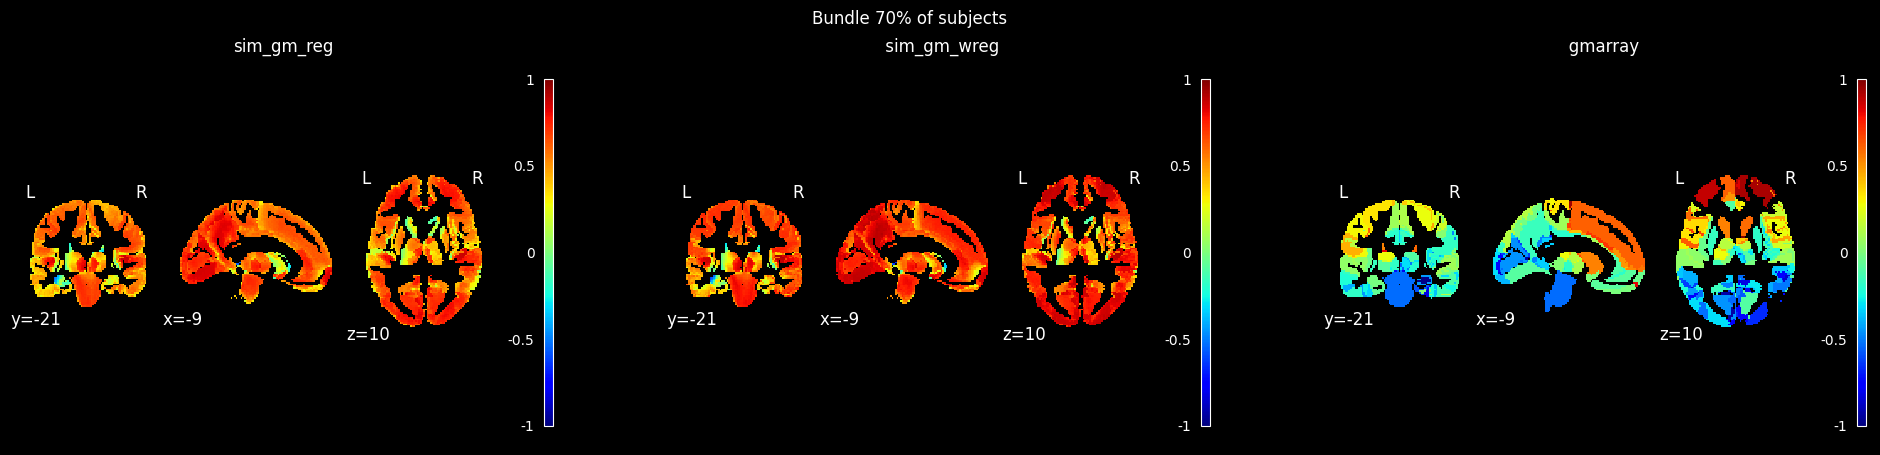

In [20]:
inpaint_mods = [sim_gm_reg, sim_gm_wreg, tmparray_gm[0]]
all_inpaints_names = f'sim_gm_reg, sim_gm_wreg,   gmarray'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, 
                                   affines, all_inpaints_names, vmin=-1, vmax=1)

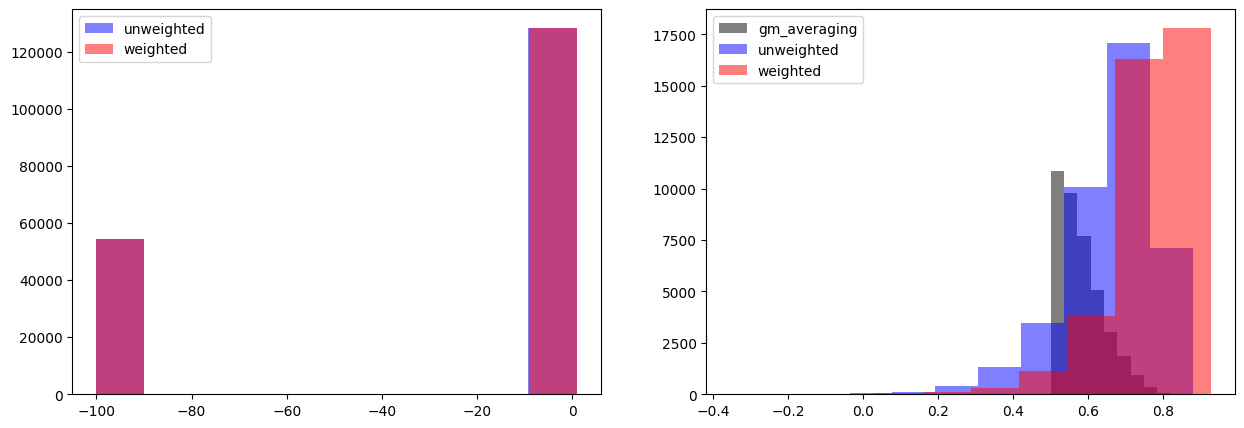

In [40]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist(sim_gm_reg[sim_voxel_reg!=-100], color='b', label='unweighted', alpha=0.5)
ax[0].hist(sim_gm_wreg[sim_voxel_wreg!=-100], color='r', label='weighted', alpha=0.5)
ax[0].legend()


good_mask = (sim_voxel_gm >= 0.5) & (sim_voxel_gm >= -1) & (sim_voxel_reg >= -1) & (sim_voxel_wreg >= -1)

ax[1].hist(sim_voxel_gm[good_mask], color='k', label='gm_averaging', alpha=0.5)
ax[1].hist(sim_gm_reg[good_mask], color='b', label='unweighted', alpha=0.5)
ax[1].hist(sim_gm_wreg[good_mask], color='r', label='weighted', alpha=0.5)
ax[1].legend()

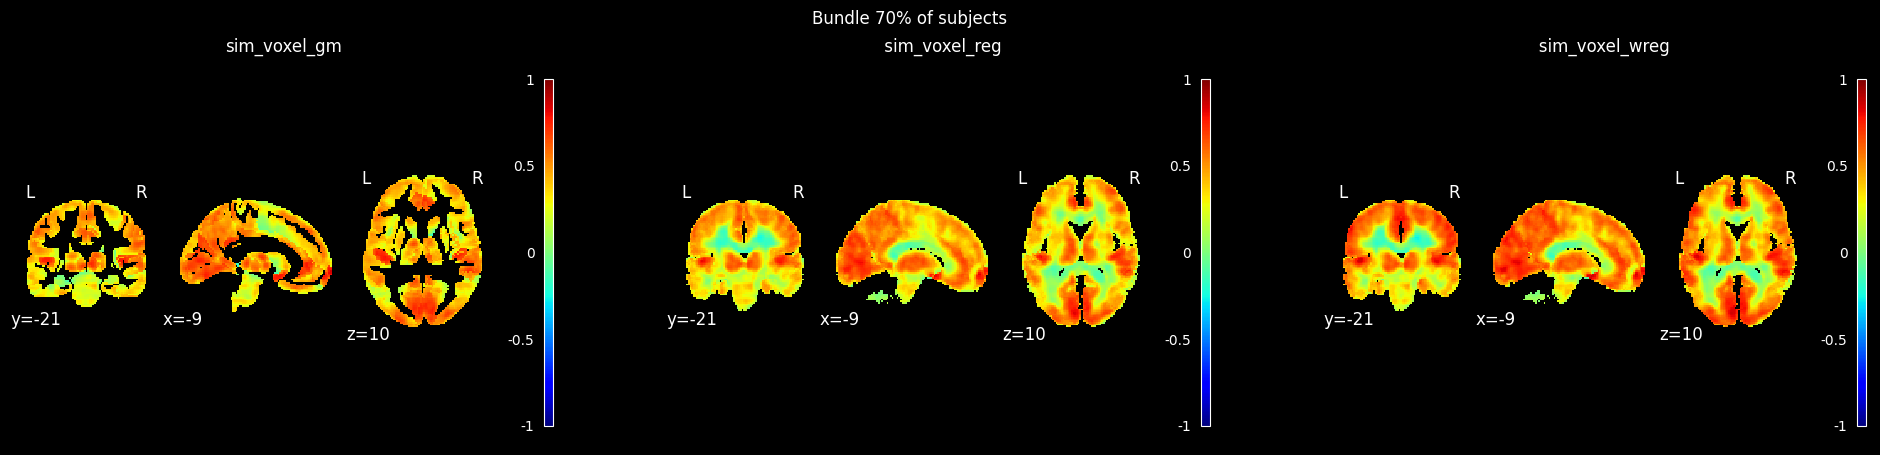

In [21]:
inpaint_mods = [sim_voxel_gm, sim_voxel_reg, sim_voxel_wreg]
all_inpaints_names = f'sim_voxel_gm, sim_voxel_reg,   sim_voxel_wreg'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, 
                                   affines, all_inpaints_names, vmin=-1, vmax=1)

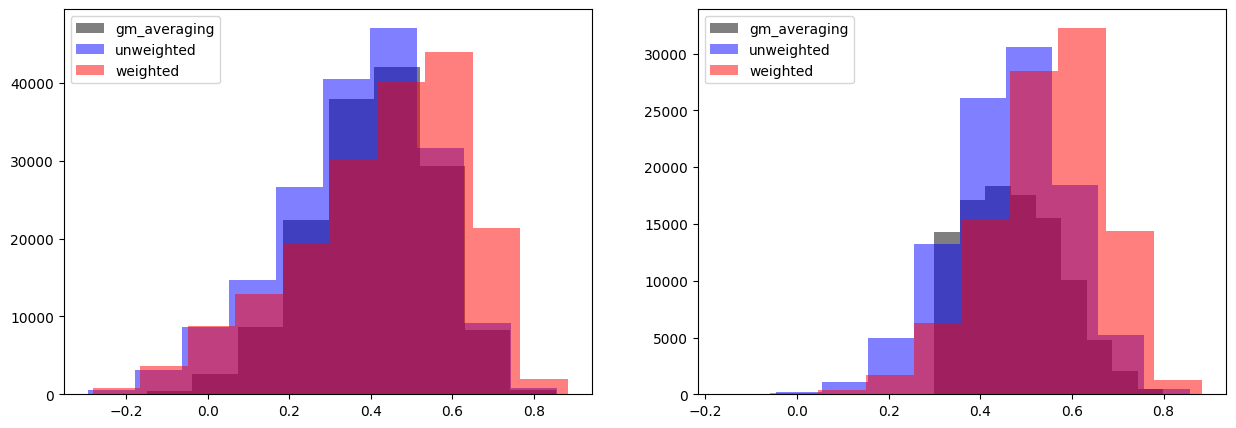

In [37]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist(sim_voxel_gm[sim_voxel_gm!=-100], color='k', label='gm_averaging', alpha=0.5)
ax[0].hist(sim_voxel_reg[sim_voxel_reg!=-100], color='b', label='unweighted', alpha=0.5)
ax[0].hist(sim_voxel_wreg[sim_voxel_wreg!=-100], color='r', label='weighted', alpha=0.5)
ax[0].legend()


good_mask = (sim_voxel_gm >= 0.3) & (sim_voxel_gm >= -1) & (sim_voxel_reg >= -1) & (sim_voxel_wreg >= -1)

ax[1].hist(sim_voxel_gm[good_mask], color='k', label='gm_averaging', alpha=0.5)
ax[1].hist(sim_voxel_reg[good_mask], color='b', label='unweighted', alpha=0.5)
ax[1].hist(sim_voxel_wreg[good_mask], color='r', label='weighted', alpha=0.5)
ax[1].legend()

In [29]:
thresh_bad = 0.1
bad_array = np.zeros_like(sim_gm_wreg)
bad_mask = (sim_voxel_gm <= thresh_bad) & (sim_voxel_gm >= -1)
good_mask = (sim_voxel_gm > thresh_bad) & (sim_voxel_gm >= -1)

bad_array[bad_mask] = 1.0
bad_array[good_mask] = -1.0
bad_array[bad_array==0] = -100

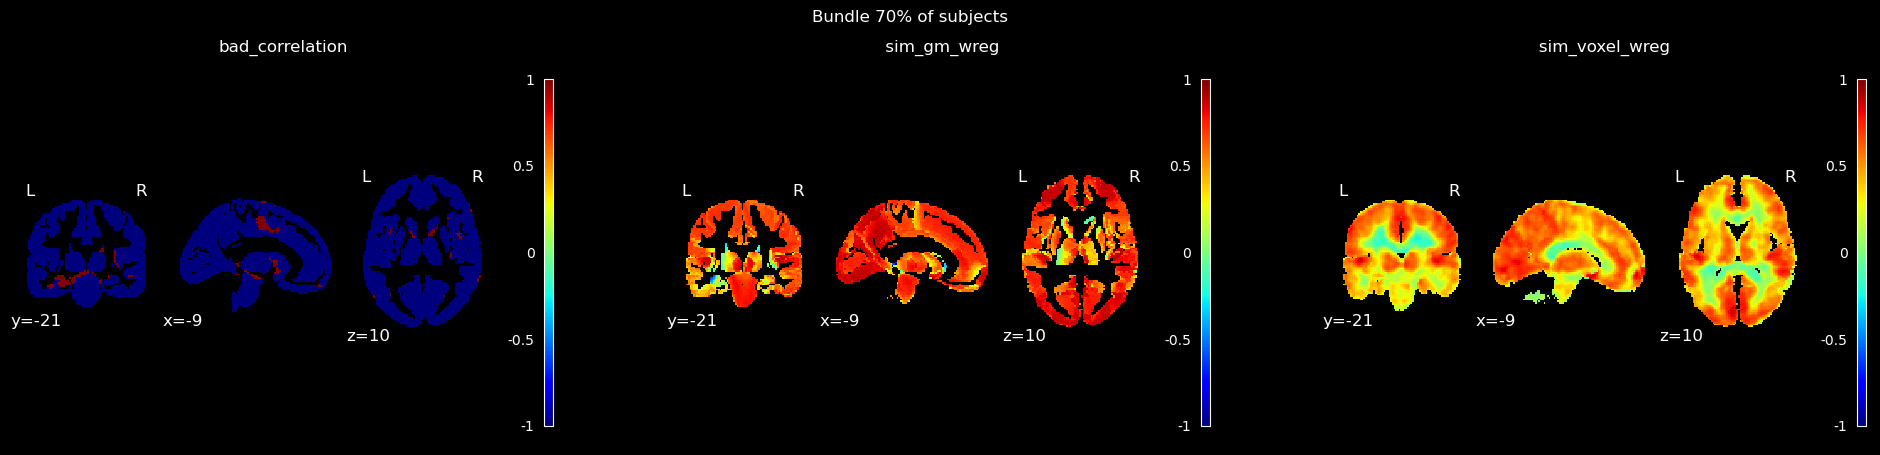

In [30]:
inpaint_mods = [bad_array, sim_gm_wreg, sim_voxel_wreg]
all_inpaints_names = f'bad_correlation, sim_gm_wreg,   sim_voxel_wreg'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, 
                                   affines, all_inpaints_names, vmin=-1, vmax=1)

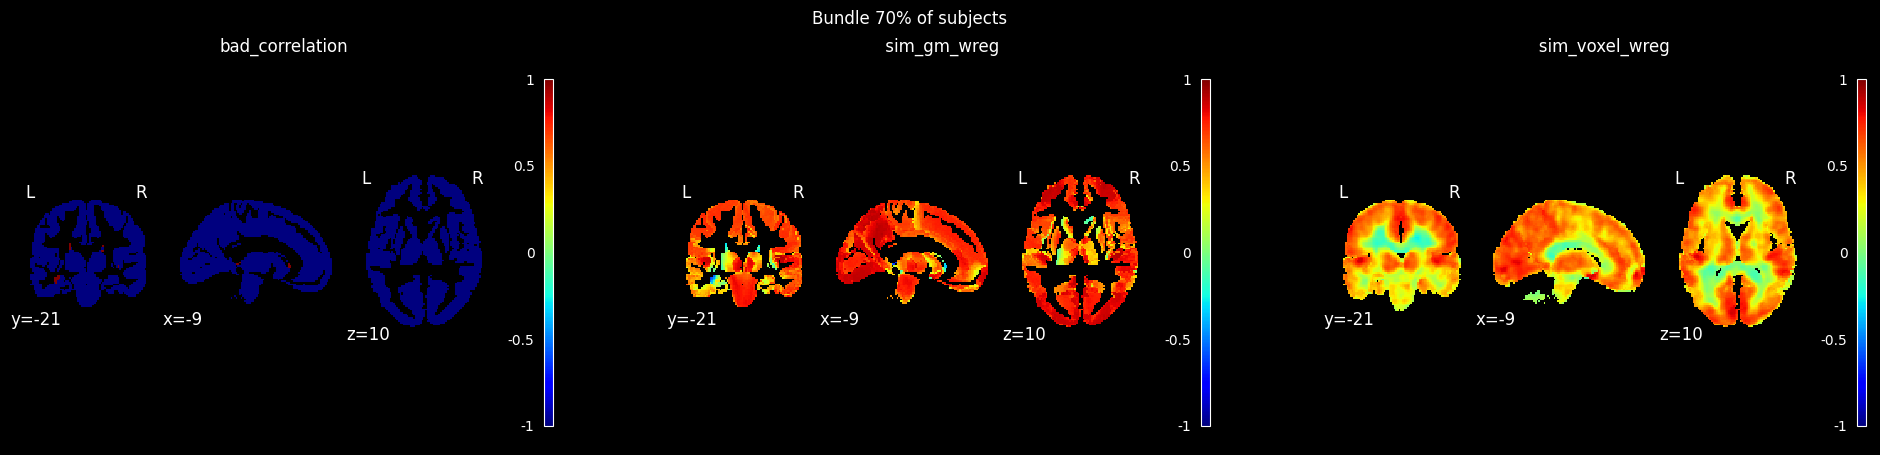

In [98]:
bad_fit = np.zeros_like(sim_gm_reg)
bad_fit_mask = ((sim_gm_wreg >= -1) & (sim_gm_wreg < -.2))
good_fit_mask = ((sim_gm_wreg >= -1) & (sim_gm_wreg >= -.2))

bad_fit[bad_fit_mask] = 1.0
bad_fit[good_fit_mask] = -1.0
bad_fit[bad_fit==0] = -100

inpaint_mods = [bad_fit, sim_gm_wreg, sim_voxel_wreg]
all_inpaints_names = f'bad_correlation, sim_gm_wreg,   sim_voxel_wreg'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, 
                                   affines, all_inpaints_names, vmin=-1, vmax=1)

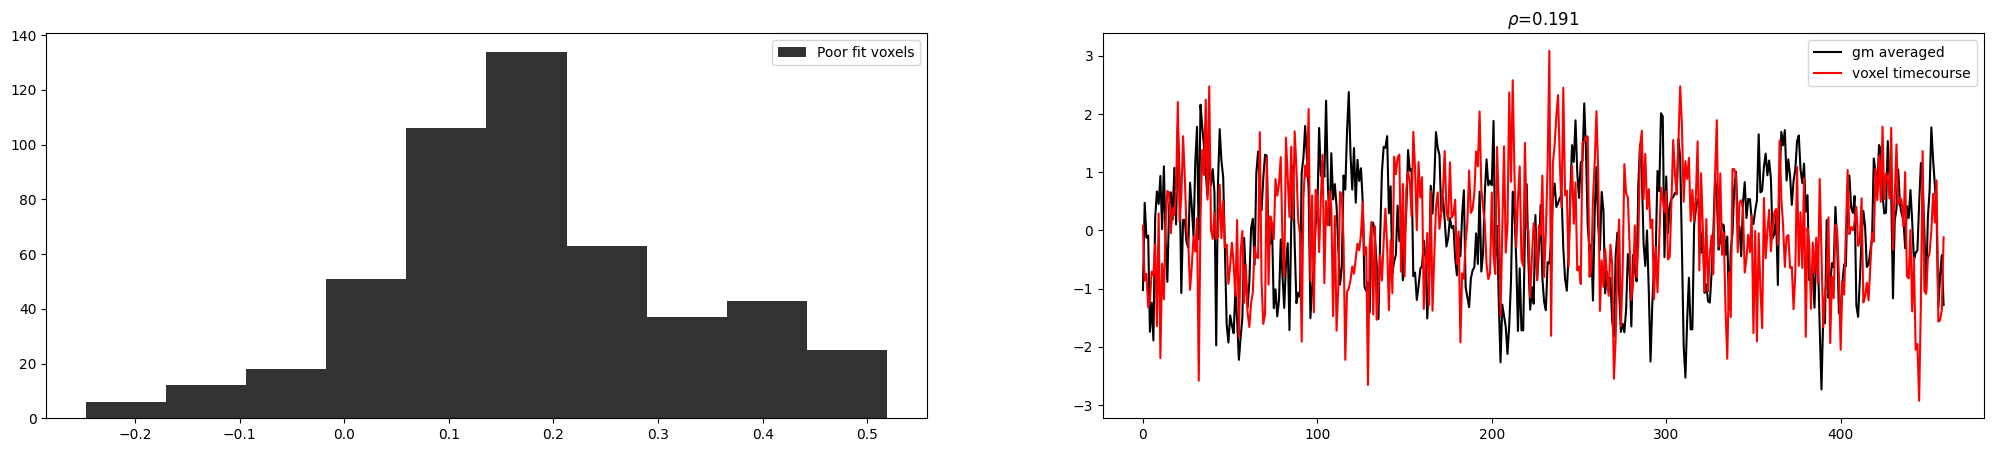

In [120]:
fig, ax = plt.subplots(1,2, figsize=(25,5))
ax[0].hist(sim_voxel_gm[bad_fit_mask], label='Poor fit voxels', color='k', alpha=0.8)
ax[0].legend()

ax[1].plot(zscore(tmparray_gm[:, bad_fit_mask][:,10]), c='k', label='gm averaged')
ax[1].set_title(rf"$\rho$={np.round(pearsonr(tmparray_gm[:, bad_fit_mask][:,10], zscore(tmparray_voxel[:, bad_fit_mask][:,10]))[0],3)}")
ax[1].plot(zscore(tmparray_voxel[:, bad_fit_mask][:,10]), c='r', label='voxel timecourse')
ax[1].legend()

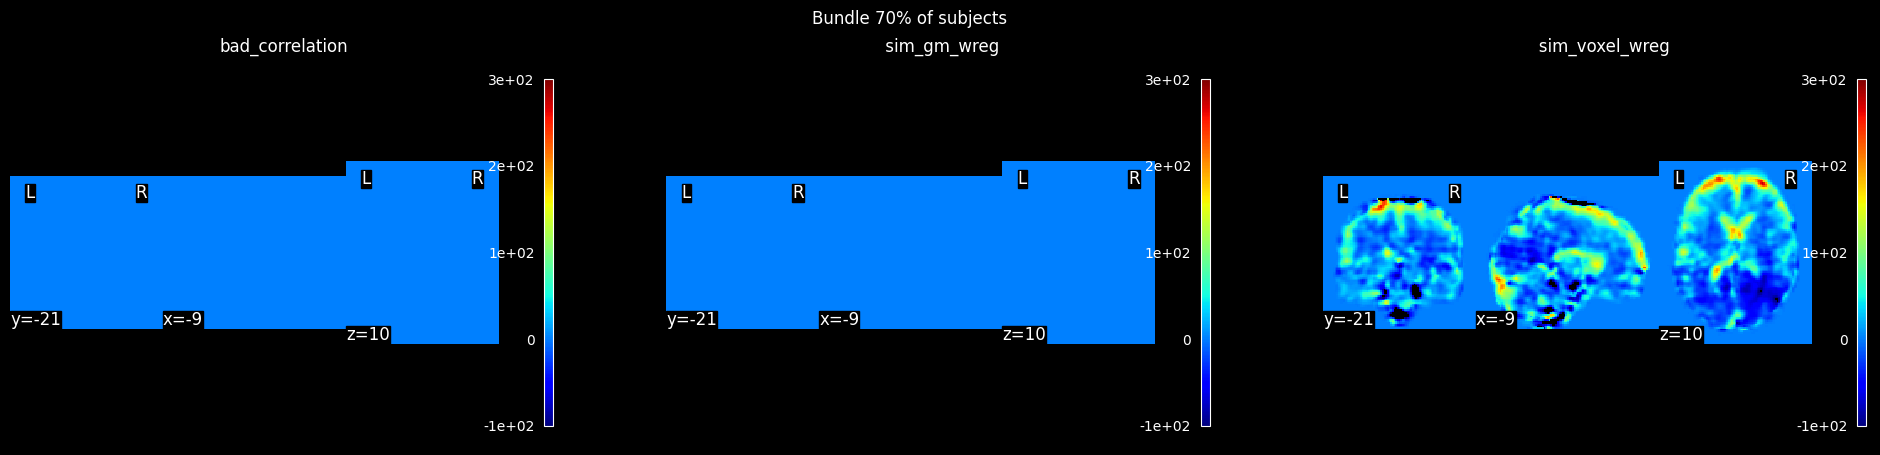

In [71]:
inpaint_mods = [np.zeros_like(sim_gm_wreg), np.zeros_like(sim_gm_wreg), tmparray_voxel[0]]
all_inpaints_names = f'bad_correlation, sim_gm_wreg,   sim_voxel_wreg'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, 
                                   affines, all_inpaints_names, vmin=-100, vmax=300)

In [ ]:
# NOTE: Close the opened h5 file
hf.close()